In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Model Fitting using PyTorch

We will fit some basic nonlinear models using PyTorch. Let us start with the change of slope model that we already studied in Lecture 9. 

### Change of Slope Model (from Lecture 9)

The model is: 
\begin{equation*}
  y_t = \beta_0 + \beta_1 t + \beta_2 \text{ReLU}(t - c_1) + \beta_3 \text{ReLU}(t - c_2) + \epsilon_t
\end{equation*}
We shall write $x_t = t$ so that the model becomes
\begin{equation*}
  y_t = \beta_0 + \beta_1 x_t + \beta_2 \text{ReLU}(x_t - c_1) + \beta_3 \text{ReLU}(x_t - c_2) + \epsilon_t
\end{equation*}
Our older code (in Lecture 9) involved calculating $RSS(c_1, c_2)$ and then optimizing over $c_1$ and $c_2$ using a grid. Today, we shall fit this model using a PyTorch neural network.  

## TTLCONS Dataset

Let us apply the change of slope model to the TTLCONS dataset. 

  observation_date  TTLCONS
0       1993-01-01   458080
1       1993-02-01   462967
2       1993-03-01   458399
3       1993-04-01   469425
4       1993-05-01   468998
5       1993-06-01   480247
6       1993-07-01   483571
7       1993-08-01   491494
8       1993-09-01   497297
9       1993-10-01   492823
    observation_date  TTLCONS
376       2024-05-01  2168211
377       2024-06-01  2143970
378       2024-07-01  2143139
379       2024-08-01  2162132
380       2024-09-01  2142427
381       2024-10-01  2176627
382       2024-11-01  2184796
383       2024-12-01  2191059
384       2025-01-01  2179942
385       2025-02-01  2195755


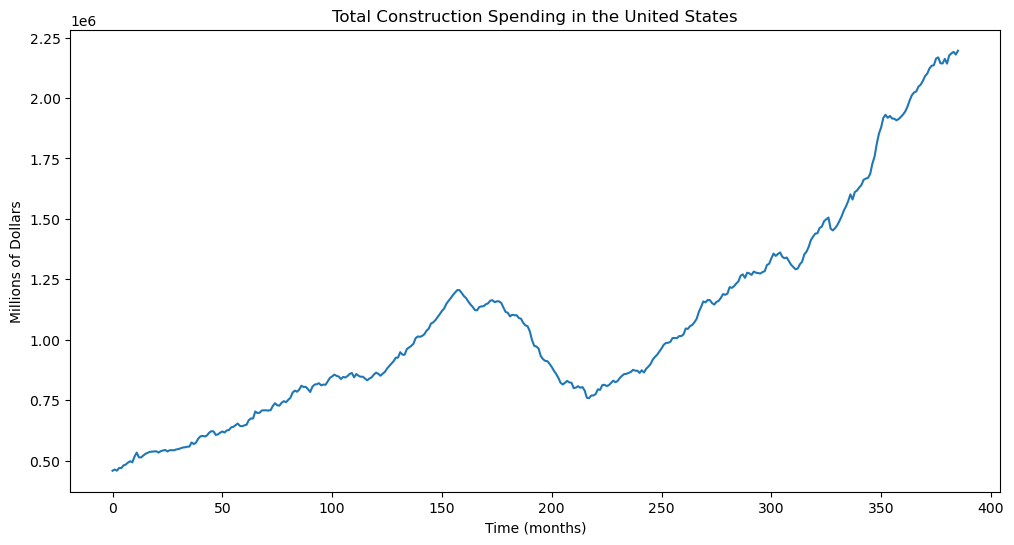

In [5]:
ttlcons = pd.read_csv('TTLCONS_14April2025.csv')
print(ttlcons.head(10))
print(ttlcons.tail(10))
y_raw = ttlcons['TTLCONS']
n = len(y_raw)
x_raw = np.arange(1, n+1)
plt.figure(figsize = (12, 6))
plt.plot(y_raw)
plt.xlabel("Time (months)")
plt.ylabel('Millions of Dollars')
plt.title("Total Construction Spending in the United States")
plt.show()

Here is the code we used in Lecture 9 for fitting this model. 

In [6]:
#Older code that we used to fit this model: 
def rss(c):
    n = len(y_raw)
    x_raw = np.arange(1, n+1)
    X = np.column_stack([np.ones(n), x_raw])
    if np.isscalar(c):
        c = [c]
    for j in range(len(c)):
        xc = ((x_raw > c[j]).astype(float))*(x_raw-c[j])
        X = np.column_stack([X, xc])
    md = sm.OLS(y_raw, X).fit()
    ans = np.sum(md.resid ** 2)
    return ans

c1_gr = np.arange(1, n-1)
c2_gr = np.arange(1, n-1)
X, Y = np.meshgrid(c1_gr, c2_gr)
g = pd.DataFrame({'x': X.flatten(), 'y': Y.flatten()})
g['rss'] = g.apply(lambda row: rss([row['x'], row['y']]), axis = 1)

min_row = g.loc[g['rss'].idxmin()]
print(min_row)
c_opt = min_row[:-1]
print(c_opt)

x      2.250000e+02
y      1.750000e+02
rss    1.368859e+12
Name: 67040, dtype: float64
x    225.0
y    175.0
Name: 67040, dtype: float64


                            OLS Regression Results                            
Dep. Variable:                TTLCONS   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     6374.
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:24:32   Log-Likelihood:                -4791.6
No. Observations:                 386   AIC:                             9591.
Df Residuals:                     382   BIC:                             9607.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.223e+05   8796.875     48.009      0.0

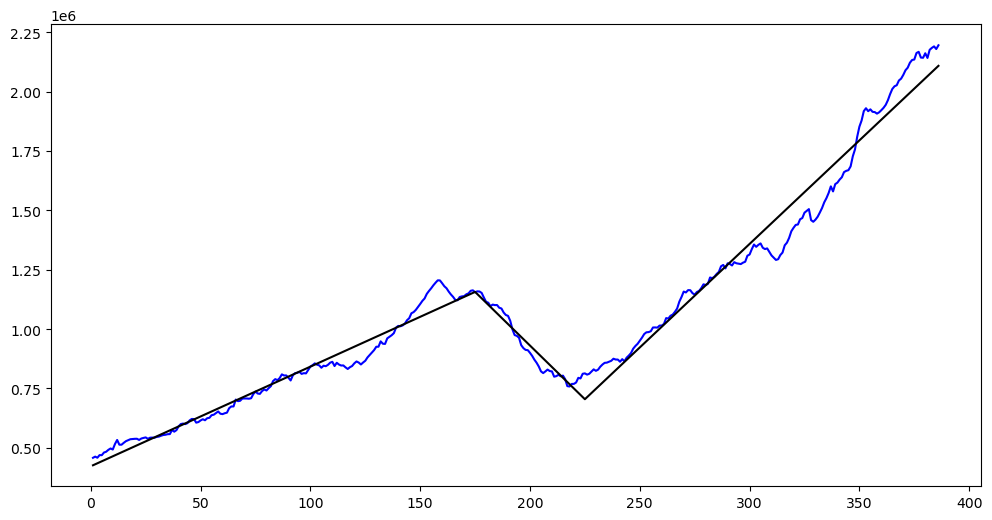

In [7]:
c = np.array(c_opt)
n = len(y_raw)
x_raw = np.arange(1, n+1)
X = np.column_stack([np.ones(n), x_raw])
if np.isscalar(c):
    c = np.array([c])
for j in range(len(c)):
    xc = ((x_raw > c[j]).astype(float))*(x_raw-c[j])
    X = np.column_stack([X, xc])
md_c2 = sm.OLS(y_raw, X).fit()
print(md_c2.summary())
rss_copt = (np.sum((md_c2.resid ** 2)))/n
print(rss_copt) #this is the smallest value of the loss achieved. 
plt.figure(figsize = (12, 6))
plt.plot(tme, y_raw, color = 'blue')
plt.plot(tme, md_c2.fittedvalues, color = 'black')
plt.show()

Now we shal fit the same model using PyTorch.

The `PiecewiseLinearModel` class is a PyTorch neural network module that defines our change of slope model. In the constructor (`__init__`), it initializes two learnable parameters: `beta`, a tensor of coefficients (starting with the intercept and slopes), and `knots`, a tensor representing the locations where slope changes can occur (these are $c_1, \dots, c_k$). Both are wrapped as `nn.Parameter` so they are optimized during training. In the `forward` method, the knots are first sorted to maintain consistent ordering. The output is then computed by applying an initial linear transformation (`beta[0] + beta[1] * x`), and adding weighted ReLU activations of the input shifted by each sorted knot (`torch.relu(x - knot)`), with corresponding weights from `beta[2:]`. This structure allows the model to learn flexible piecewise linear relationships during optimization.


In [8]:
#Now we shall fit this using a neural network model in pytorch: 
import torch
import torch.nn as nn
import torch.optim as optim

#In this code, we have to supply the initial values for both the knots and the coefficients. 

class PiecewiseLinearModel(nn.Module):
    def __init__(self, knots_init, beta_init):
        super().__init__()
        self.num_knots = len(knots_init)
        self.beta = nn.Parameter(torch.tensor(beta_init, dtype=torch.float32)) 
        self.knots = nn.Parameter(torch.tensor(knots_init, dtype=torch.float32))

    def forward(self, x):
        knots_sorted, _ = torch.sort(self.knots)
        out = self.beta[0] + self.beta[1] * x
        for j in range(self.num_knots):
            out += self.beta[j + 2] * torch.relu(x - knots_sorted[j])
        return out

We do not apply the model to the raw data but we scale the raw data first. The algorithm for parameter fitting will work better with scaled data as opposed to raw data. 

The code below first standardizes the raw input arrays `y_raw` and `x_raw` by subtracting their means and dividing by their standard deviations, resulting in `y_scaled` and `x_scaled`, respectively. This scaling step ensures that both inputs have mean 0 and standard deviation 1, which helps neural network training converge faster and more reliably. After scaling, the arrays are converted into PyTorch tensors (`y_torch` and `x_torch`) with `dtype=torch.float32`, and an additional singleton dimension is added using `unsqueeze(1)` to ensure each data point is treated as a one-dimensional feature vector. Conversion to PyTorch tensors is necessary because PyTorch models and optimization routines (like gradient computation and parameter updates) operate on tensors, not on NumPy arrays.

In [9]:
#Below we first scale y_raw and x_raw and then convert them to tensors for training the neural network model
y_scaled = (y_raw - np.mean(y_raw))/(np.std(y_raw))
x_scaled = (x_raw - np.mean(x_raw))/(np.std(x_raw))
y_torch = torch.tensor(y_scaled, dtype = torch.float32).unsqueeze(1)
x_torch = torch.tensor(x_scaled, dtype = torch.float32).unsqueeze(1)

Before obtaining parameter estimates via PyTorch, let us first use our older code (from Lecture 9) on the scaled data. 

x      0.282693
y     -0.166026
rss    7.560319
Name: 67388, dtype: float64
x    0.282693
y   -0.166026
Name: 67388, dtype: float64
                            OLS Regression Results                            
Dep. Variable:                TTLCONS   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     6374.
Date:                Fri, 25 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:25:07   Log-Likelihood:                 211.34
No. Observations:                 386   AIC:                            -414.7
Df Residuals:                     382   BIC:                            -398.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]

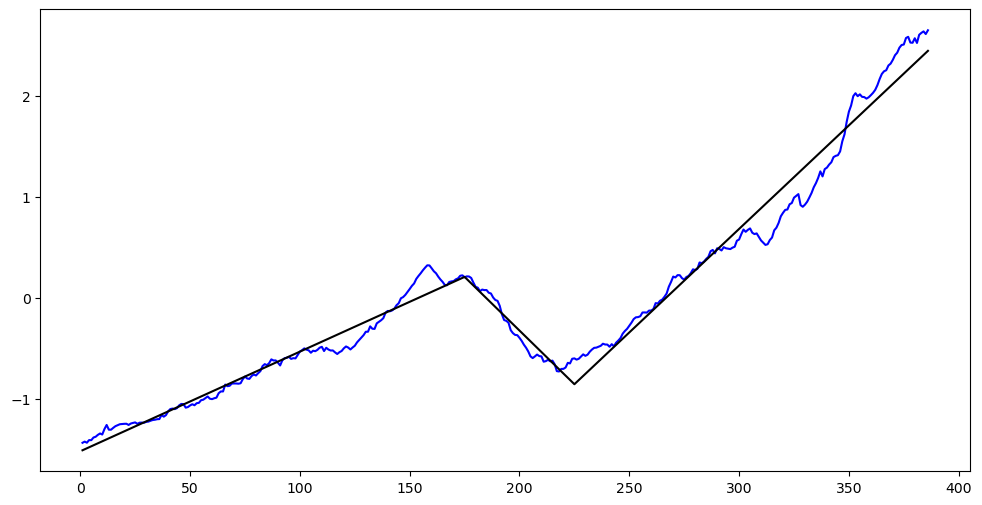

In [10]:
#Older code that we used to fit this model: 
def rss(c):
    n = len(y_scaled)
    x_raw = np.arange(1, n+1)
    x_scaled = (x_raw - np.mean(x_raw))/(np.std(x_raw))
    X = np.column_stack([np.ones(n), x_scaled])
    if np.isscalar(c):
        c = [c]
    for j in range(len(c)):
        xc = ((x_scaled > c[j]).astype(float))*(x_scaled-c[j])
        X = np.column_stack([X, xc])
    md = sm.OLS(y_scaled, X).fit()
    ans = np.sum(md.resid ** 2)
    return ans

c1_gr = np.sort(x_scaled)
c2_gr = np.sort(x_scaled)
X, Y = np.meshgrid(c1_gr, c2_gr)
g = pd.DataFrame({'x': X.flatten(), 'y': Y.flatten()})
g['rss'] = g.apply(lambda row: rss([row['x'], row['y']]), axis = 1)

min_row = g.loc[g['rss'].idxmin()]
print(min_row)
c_opt = min_row[:-1]
print(c_opt)

c = np.array(c_opt)
n = len(y_scaled)
X = np.column_stack([np.ones(n), x_scaled])
if np.isscalar(c):
    c = np.array([c])
for j in range(len(c)):
    xc = ((x_scaled > c[j]).astype(float))*(x_scaled-c[j])
    X = np.column_stack([X, xc])
md_c2 = sm.OLS(y_scaled, X).fit()
print(md_c2.summary())
rss_copt = (np.sum((md_c2.resid ** 2)))/n
print(rss_copt) #this is the smallest value of the loss achieved. 
plt.figure(figsize = (12, 6))
plt.plot(tme, y_scaled, color = 'blue')
plt.plot(tme, md_c2.fittedvalues, color = 'black')
plt.show()

We are now ready to use PyTorch for parameter estimation. The first step is to obtain suitable initial estimates for the parameters. These are deduced as follows. We take $c_1, \dots, c_k$ to be quantiles of the scaled covariate at equal levels. Then we fit the model with $c_1, \dots, c_k$ fixed at these initial values, and obtain the initial values of the coefficients. 

In [11]:
k = 2 #this is the number of knots
quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_scaled, quantile_levels)

n = len(y_scaled)
X = np.column_stack([np.ones(n), x_scaled])
for j in range(k):
    xc = ((x_scaled > knots_init[j]).astype(float))*(x_scaled-knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(y_scaled, X).fit()
beta_init = md_init.params.values
print(knots_init)
print(beta_init)


[-0.57585648  0.57585648]
[ 0.56600869  1.2199186  -1.42682417  2.75171746]


The next code line `md_nn = PiecewiseLinearModel(knots_init=knots_init, beta_init=beta_init)` creates an instance of the custom neural network model `PiecewiseLinearModel`. It initializes the learnable parameters of the model: the knot locations are set to the values provided in `knots_init`, and the coefficients are set to `beta_init`. This prepares the model for training by defining its initial piecewise linear structure.

In [12]:
md_nn = PiecewiseLinearModel(knots_init = knots_init, beta_init = beta_init)
#This code creates an instance of our custom neural network class
#It also initializes the knots at knots_init

The next block of code sets up and runs the training loop for the `PiecewiseLinearModel`. The `Adam` optimizer is initialized with the model’s parameters and a learning rate of 0.01, and the loss function is set to mean squared error (`MSELoss`). For 20,000 epochs, the code repeatedly performs one training step: it clears previous gradients with `optimizer.zero_grad()`, computes predictions `y_pred` by passing `x_torch` through the model, evaluates the loss between predictions and true values, backpropagates the loss with `loss.backward()`, and updates the model parameters using `optimizer.step()`. Every 100 epochs, the current epoch and loss value are printed to monitor training progress. Running the code multiple times may be necessary to ensure good convergence, especially for non-convex optimization problems.

In [13]:
optimizer = optim.Adam(md_nn.parameters(), lr = 0.01)
loss_fn = nn.MSELoss()

for epoch in range(20000): 
    optimizer.zero_grad()
    y_pred = md_nn(x_torch)
    loss = loss_fn(y_pred, y_torch)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
#Run this code a few times to be sure of convergence. 

Epoch 0, Loss: 0.0429
Epoch 100, Loss: 0.0247
Epoch 200, Loss: 0.0219
Epoch 300, Loss: 0.0207
Epoch 400, Loss: 0.0201
Epoch 500, Loss: 0.0198
Epoch 600, Loss: 0.0197
Epoch 700, Loss: 0.0197
Epoch 800, Loss: 0.0197
Epoch 900, Loss: 0.0196
Epoch 1000, Loss: 0.0196
Epoch 1100, Loss: 0.0196
Epoch 1200, Loss: 0.0196
Epoch 1300, Loss: 0.0196
Epoch 1400, Loss: 0.0196
Epoch 1500, Loss: 0.0196
Epoch 1600, Loss: 0.0196
Epoch 1700, Loss: 0.0196
Epoch 1800, Loss: 0.0196
Epoch 1900, Loss: 0.0196
Epoch 2000, Loss: 0.0196
Epoch 2100, Loss: 0.0196
Epoch 2200, Loss: 0.0196
Epoch 2300, Loss: 0.0196
Epoch 2400, Loss: 0.0196
Epoch 2500, Loss: 0.0196
Epoch 2600, Loss: 0.0196
Epoch 2700, Loss: 0.0196
Epoch 2800, Loss: 0.0196
Epoch 2900, Loss: 0.0196
Epoch 3000, Loss: 0.0196
Epoch 3100, Loss: 0.0196
Epoch 3200, Loss: 0.0196
Epoch 3300, Loss: 0.0196
Epoch 3400, Loss: 0.0196
Epoch 3500, Loss: 0.0196
Epoch 3600, Loss: 0.0196
Epoch 3700, Loss: 0.0196
Epoch 3800, Loss: 0.0196
Epoch 3900, Loss: 0.0196
Epoch 4000, 

The next code prints out the current loss value, the estimated model coefficients (`beta`), and the estimated knot locations after training. The `detach().numpy()` calls are used to move each tensor from the computation graph to a regular NumPy array so they can be easily printed or further processed without tracking gradients. Finally, it prints `rss_copt`, which represents the smallest residual sum of squares (RSS) achieved with two knots during training, providing a measure of the model’s fit quality.


In [14]:
print(loss.detach().numpy())
print(md_nn.beta.detach().numpy())
print(md_nn.knots.detach().numpy())
print(rss_copt) #this is the smallest RSS with two knots

0.019580817
[ 0.39307612  1.099781   -3.42655     4.6143637 ]
[-0.16831267  0.2858241 ]
0.019586318618132627


The next code computes the model’s fitted values by passing `x_torch` through the trained `PiecewiseLinearModel` and applying `.detach().numpy()` to convert the output tensor into a NumPy array, which disconnects it from the PyTorch computation graph. The fitted values (`nn_fits`) represent the model’s predicted outputs on the training data and are printed for inspection.


In [15]:
nn_fits = md_nn(x_torch).detach().numpy()
print(nn_fits)

[[-1.5068719 ]
 [-1.4970021 ]
 [-1.4871321 ]
 [-1.4772625 ]
 [-1.4673924 ]
 [-1.4575226 ]
 [-1.4476528 ]
 [-1.437783  ]
 [-1.4279132 ]
 [-1.4180431 ]
 [-1.4081733 ]
 [-1.3983035 ]
 [-1.3884337 ]
 [-1.3785639 ]
 [-1.3686938 ]
 [-1.358824  ]
 [-1.3489542 ]
 [-1.3390844 ]
 [-1.3292146 ]
 [-1.3193445 ]
 [-1.3094747 ]
 [-1.2996049 ]
 [-1.2897351 ]
 [-1.2798653 ]
 [-1.2699952 ]
 [-1.2601254 ]
 [-1.2502556 ]
 [-1.2403858 ]
 [-1.230516  ]
 [-1.2206461 ]
 [-1.2107761 ]
 [-1.2009063 ]
 [-1.1910365 ]
 [-1.1811666 ]
 [-1.1712968 ]
 [-1.1614268 ]
 [-1.151557  ]
 [-1.1416872 ]
 [-1.1318171 ]
 [-1.1219475 ]
 [-1.1120775 ]
 [-1.1022077 ]
 [-1.0923378 ]
 [-1.082468  ]
 [-1.0725982 ]
 [-1.0627282 ]
 [-1.0528584 ]
 [-1.0429885 ]
 [-1.0331187 ]
 [-1.0232489 ]
 [-1.0133789 ]
 [-1.003509  ]
 [-0.9936393 ]
 [-0.98376936]
 [-0.97389954]
 [-0.9640296 ]
 [-0.9541598 ]
 [-0.94429   ]
 [-0.93442005]
 [-0.92455024]
 [-0.9146803 ]
 [-0.9048105 ]
 [-0.8949407 ]
 [-0.88507074]
 [-0.8752009 ]
 [-0.8653311 ]
 [-0.85546

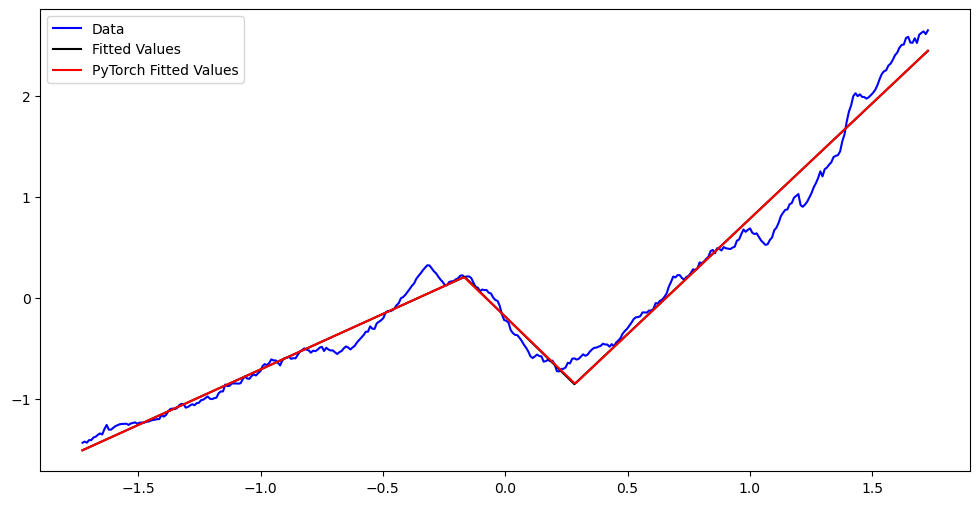

In [16]:
plt.figure(figsize = (12, 6))
plt.plot(x_scaled, y_scaled, color = 'blue', label = 'Data')
plt.plot(x_scaled, md_c2.fittedvalues, color = 'black', label = 'Fitted Values')
plt.plot(x_scaled, nn_fits, color = 'red', label = 'PyTorch Fitted Values')
plt.legend()
plt.show()

## Larger number of knots and Regularization 

Below we apply the code for $k$ larger than 2. First we take $k = 6$. 

In [17]:
k = 6 #this is the number of knots
quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_scaled, quantile_levels)

n = len(y_scaled)
X = np.column_stack([np.ones(n), x_scaled])
for j in range(k):
    xc = ((x_scaled > knots_init[j]).astype(float))*(x_scaled-knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(y_scaled, X).fit()
beta_init = md_init.params.values
print(knots_init)
print(beta_init)

[-1.23397816 -0.7403869  -0.24679563  0.24679563  0.7403869   1.23397816]
[ 0.15436343  0.91474382 -0.0392841   0.85800737 -3.89942     4.1298293
 -0.33642219  2.10097127]


In [18]:
md_nn = PiecewiseLinearModel(knots_init = knots_init, beta_init = beta_init)
#This code creates an instance of our custom neural network class
#It also initializes the knots at knots_init

In [19]:
optimizer = optim.Adam(md_nn.parameters(), lr = 0.01)
loss_fn = nn.MSELoss()

for epoch in range(20000): 
    optimizer.zero_grad()
    y_pred = md_nn(x_torch)
    loss = loss_fn(y_pred, y_torch)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
#Run this code a few times to be sure of convergence. 

Epoch 0, Loss: 0.0057
Epoch 100, Loss: 0.0051
Epoch 200, Loss: 0.0049
Epoch 300, Loss: 0.0049
Epoch 400, Loss: 0.0048
Epoch 500, Loss: 0.0047
Epoch 600, Loss: 0.0047
Epoch 700, Loss: 0.0046
Epoch 800, Loss: 0.0046
Epoch 900, Loss: 0.0045
Epoch 1000, Loss: 0.0045
Epoch 1100, Loss: 0.0045
Epoch 1200, Loss: 0.0044
Epoch 1300, Loss: 0.0044
Epoch 1400, Loss: 0.0044
Epoch 1500, Loss: 0.0045
Epoch 1600, Loss: 0.0044
Epoch 1700, Loss: 0.0044
Epoch 1800, Loss: 0.0044
Epoch 1900, Loss: 0.0043
Epoch 2000, Loss: 0.0044
Epoch 2100, Loss: 0.0043
Epoch 2200, Loss: 0.0043
Epoch 2300, Loss: 0.0043
Epoch 2400, Loss: 0.0043
Epoch 2500, Loss: 0.0043
Epoch 2600, Loss: 0.0043
Epoch 2700, Loss: 0.0042
Epoch 2800, Loss: 0.0043
Epoch 2900, Loss: 0.0042
Epoch 3000, Loss: 0.0042
Epoch 3100, Loss: 0.0042
Epoch 3200, Loss: 0.0042
Epoch 3300, Loss: 0.0042
Epoch 3400, Loss: 0.0042
Epoch 3500, Loss: 0.0042
Epoch 3600, Loss: 0.0042
Epoch 3700, Loss: 0.0042
Epoch 3800, Loss: 0.0044
Epoch 3900, Loss: 0.0042
Epoch 4000, 

In [20]:
print(loss.detach().numpy())
print(md_nn.beta.detach().numpy())
print(md_nn.knots.detach().numpy())
print(rss_copt) #this is the smallest RSS with two knots

0.004008136
[ 0.2617606   0.9924645  -0.81128037  2.1586957  -4.6034064   4.16186
 -3.8148813   5.3695893 ]
[-0.7957666  -0.6338984  -0.26267192  0.2348822   0.99296016  1.0693403 ]
0.019586318618132627


In [21]:
nn_fits = md_nn(x_torch).detach().numpy()
print(nn_fits)

[[-1.45279074e+00]
 [-1.44388390e+00]
 [-1.43497717e+00]
 [-1.42607045e+00]
 [-1.41716361e+00]
 [-1.40825689e+00]
 [-1.39935017e+00]
 [-1.39044333e+00]
 [-1.38153660e+00]
 [-1.37262988e+00]
 [-1.36372316e+00]
 [-1.35481632e+00]
 [-1.34590960e+00]
 [-1.33700287e+00]
 [-1.32809603e+00]
 [-1.31918931e+00]
 [-1.31028259e+00]
 [-1.30137575e+00]
 [-1.29246902e+00]
 [-1.28356230e+00]
 [-1.27465546e+00]
 [-1.26574874e+00]
 [-1.25684190e+00]
 [-1.24793530e+00]
 [-1.23902845e+00]
 [-1.23012161e+00]
 [-1.22121501e+00]
 [-1.21230817e+00]
 [-1.20340145e+00]
 [-1.19449472e+00]
 [-1.18558788e+00]
 [-1.17668116e+00]
 [-1.16777432e+00]
 [-1.15886772e+00]
 [-1.14996088e+00]
 [-1.14105403e+00]
 [-1.13214743e+00]
 [-1.12324059e+00]
 [-1.11433375e+00]
 [-1.10542703e+00]
 [-1.09652030e+00]
 [-1.08761358e+00]
 [-1.07870674e+00]
 [-1.06980002e+00]
 [-1.06089330e+00]
 [-1.05198646e+00]
 [-1.04307985e+00]
 [-1.03417301e+00]
 [-1.02526617e+00]
 [-1.01635945e+00]
 [-1.00745273e+00]
 [-9.98546004e-01]
 [-9.8963916

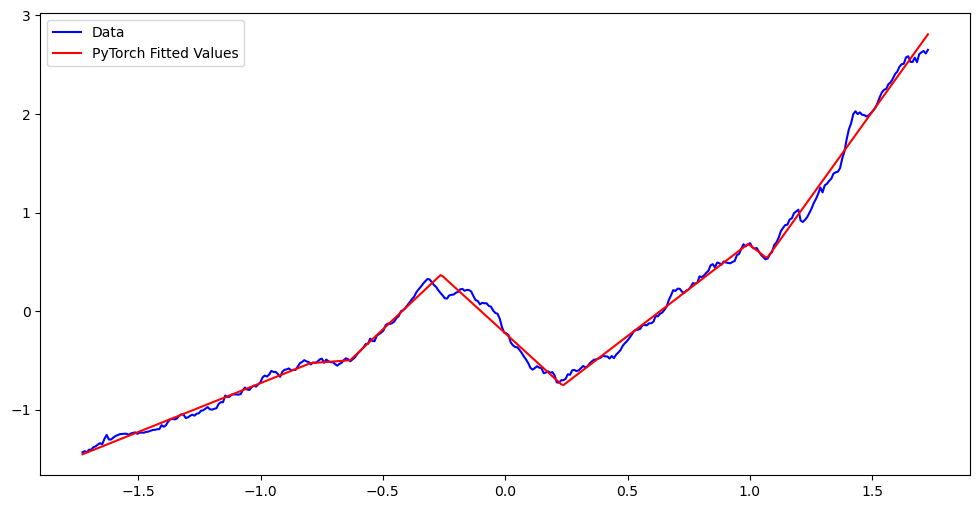

In [22]:
plt.figure(figsize = (12, 6))
plt.plot(x_scaled, y_scaled, color = 'blue', label = 'Data')
#plt.plot(x_scaled, md_c2.fittedvalues, color = 'black', label = 'Fitted Values')
plt.plot(x_scaled, nn_fits, color = 'red', label = 'PyTorch Fitted Values')
plt.legend()
plt.show()

Remember that previously we were not quite able to fit the model for $k = 6$. The number of unknown knots $c_1, \dots, c_k$ was too big to do a brute force search. Next we take $k$ to be a larger number ($k = 50$) and apply the method. Here we need to add regularization otherwise the model will essentially overfit the data. We will use the same regularization that we previously used ($L_1$ norm of the coefficients). 

In [26]:
k = 50 #this is the number of knots
quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_scaled, quantile_levels)

n = len(y_scaled)
X = np.column_stack([np.ones(n), x_scaled])
for j in range(k):
    xc = ((x_scaled > knots_init[j]).astype(float))*(x_scaled-knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(y_scaled, X).fit()
beta_init = md_init.params.values
print(knots_init)
print(beta_init)

[-1.65982161 -1.59207379 -1.52432596 -1.45657814 -1.38883032 -1.3210825
 -1.25333468 -1.18558686 -1.11783904 -1.05009122 -0.9823434  -0.91459558
 -0.84684776 -0.77909994 -0.71135212 -0.6436043  -0.57585648 -0.50810865
 -0.44036083 -0.37261301 -0.30486519 -0.23711737 -0.16936955 -0.10162173
 -0.03387391  0.03387391  0.10162173  0.16936955  0.23711737  0.30486519
  0.37261301  0.44036083  0.50810865  0.57585648  0.6436043   0.71135212
  0.77909994  0.84684776  0.91459558  0.9823434   1.05009122  1.11783904
  1.18558686  1.25333468  1.3210825   1.38883032  1.45657814  1.52432596
  1.59207379  1.65982161]
[ 1.03030663e+00  1.43189061e+00 -1.58045417e-01 -9.62720527e-01
 -1.59327404e-01  1.03424172e+00  9.27391404e-02 -8.99195890e-01
  5.36868641e-01  9.76505452e-01 -1.29730204e+00  1.55448090e+00
 -1.60634200e+00  5.00523979e-01 -3.03969836e-01 -1.02428612e+00
  3.60217386e-01  2.15826811e+00 -2.02834481e-03 -4.97160969e-02
  1.18893426e+00 -9.17836279e-01 -5.60822348e+00  5.00254824e+00
 

In [30]:
md_nn = PiecewiseLinearModel(knots_init = knots_init, beta_init = beta_init)

In [31]:
#Adding a regularizer to the loss function.
optimizer = optim.Adam(md_nn.parameters(), lr = 0.01)
loss_fn = nn.MSELoss()
lambda_l1 = 0.001 #this works pretty well
#lambda_l2 = .002

for epoch in range(30000): 
    optimizer.zero_grad()
    y_pred = md_nn(x_torch)
    mse_loss = loss_fn(y_pred, y_torch)
    l1_penalty = torch.norm(md_nn.beta[2:], p = 1) 
    #l2_penalty = torch.sum(md_nn.beta[2:] ** 2)
    loss = mse_loss + lambda_l1 * l1_penalty
    #loss = mse_loss + lambda_l2 * l2_penalty
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
#Run this code a few times to be sure of convergence. 

Epoch 0, Loss: 0.0947
Epoch 100, Loss: 0.0921
Epoch 200, Loss: 0.0902
Epoch 300, Loss: 0.0880
Epoch 400, Loss: 0.0856
Epoch 500, Loss: 0.0830
Epoch 600, Loss: 0.0807
Epoch 700, Loss: 0.0784
Epoch 800, Loss: 0.0759
Epoch 900, Loss: 0.0734
Epoch 1000, Loss: 0.0712
Epoch 1100, Loss: 0.0692
Epoch 1200, Loss: 0.0673
Epoch 1300, Loss: 0.0654
Epoch 1400, Loss: 0.0634
Epoch 1500, Loss: 0.0614
Epoch 1600, Loss: 0.0594
Epoch 1700, Loss: 0.0575
Epoch 1800, Loss: 0.0557
Epoch 1900, Loss: 0.0539
Epoch 2000, Loss: 0.0521
Epoch 2100, Loss: 0.0511
Epoch 2200, Loss: 0.0489
Epoch 2300, Loss: 0.0475
Epoch 2400, Loss: 0.0460
Epoch 2500, Loss: 0.0445
Epoch 2600, Loss: 0.0430
Epoch 2700, Loss: 0.0414
Epoch 2800, Loss: 0.0398
Epoch 2900, Loss: 0.0382
Epoch 3000, Loss: 0.0368
Epoch 3100, Loss: 0.0354
Epoch 3200, Loss: 0.0342
Epoch 3300, Loss: 0.0331
Epoch 3400, Loss: 0.0322
Epoch 3500, Loss: 0.0316
Epoch 3600, Loss: 0.0310
Epoch 3700, Loss: 0.0306
Epoch 3800, Loss: 0.0301
Epoch 3900, Loss: 0.0297
Epoch 4000, 

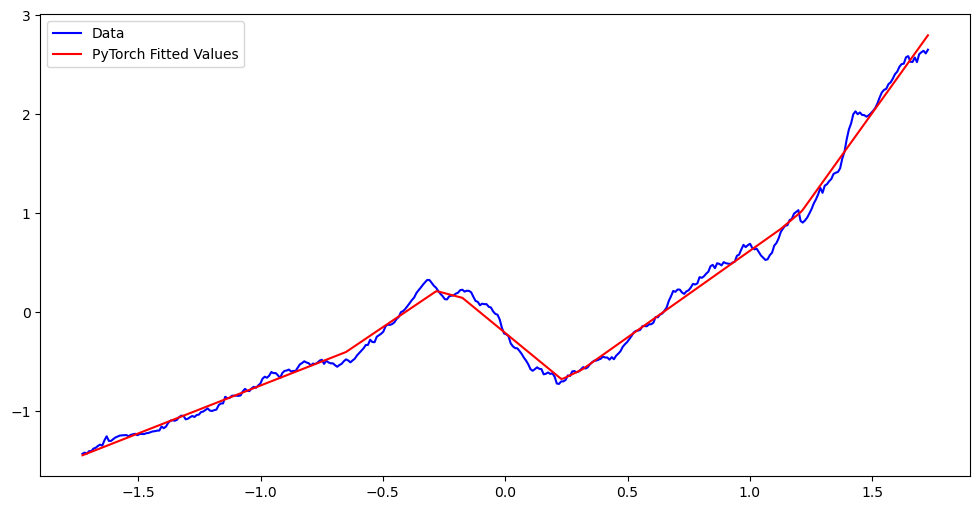

In [32]:
nn_fits = md_nn(x_torch).detach().numpy()
plt.figure(figsize = (12, 6))
plt.plot(x_scaled, y_scaled, color = 'blue', label = 'Data')
#plt.plot(x_scaled, md_c2.fittedvalues, color = 'black', label = 'Fitted Values')
plt.plot(x_scaled, nn_fits, color = 'red', label = 'PyTorch Fitted Values')
plt.legend()
plt.show()

## AutoRegression

Next we fit the NonLinear AR(1) model. We will generate a simulated dataset using the following equation: 
\begin{equation*}
   y_t = \frac{2 y_{t-1}}{1 + 0.8 y_{t-1}^2} + \epsilon_t
\end{equation*}
where $\epsilon_t \overset{\text{i.i.d}}{\sim} \text{uniform}(-1, 1)$. 

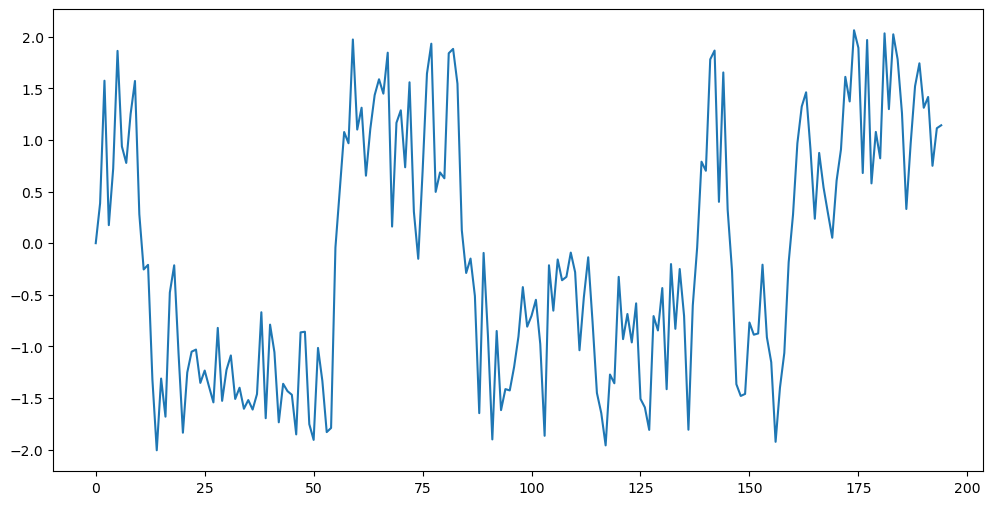

In [35]:
n = 195
#n = 240
rng = np.random.default_rng(seed = 40)
eps = rng.uniform(low = -1.0, high = 1.0, size = n) 
#sig = 1.0
#eps = rng.normal(loc = 0.0, scale = sig, size = n)

y_sim = np.full(n, 0, dtype = float) 
for i in range(1, n):
    y_sim[i] = ((2*y_sim[i-1])/(1 + 0.8 * (y_sim[i-1] ** 2))) + eps[i]

plt.figure(figsize = (12, 6))
plt.plot(y_sim)
plt.show()

Looking at the dataset, it is natural to predict the next values at around level 1. The usual linear AR(1) model predicts closer to the overall mean which is not ideal in this situation. In contrast, the nonlinear AR(1) model obtains predictions that match with intuition. 

The function $g(\cdot)$ which generated the data $y_t = g(y_{t-1}) + \epsilon_t$ is plotted below. 

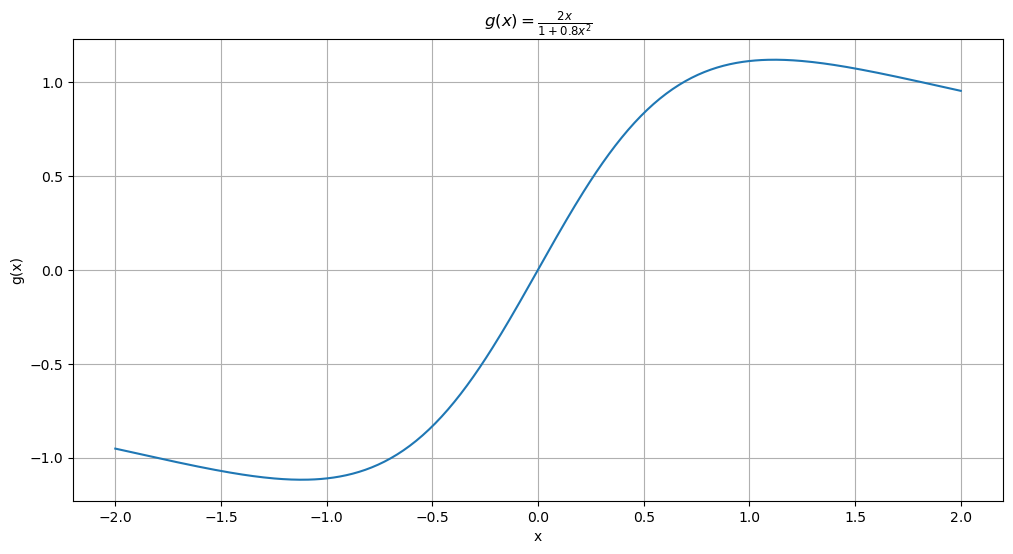

In [36]:
def g(x):
    return 2 * x / (1 + 0.8 * x**2)

x_vals = np.linspace(-2, 2, 400)
y_vals = g(x_vals)

# Plot the function
plt.figure(figsize = (12, 6))
plt.plot(x_vals, y_vals)
plt.title(r'$g(x) = \frac{2x}{1 + 0.8x^2}$')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.grid(True)
plt.show()

Let us first fit the usual AR(1) model, and look at the predictions. 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  195
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -197.447
Date:                Fri, 25 Apr 2025   AIC                            400.893
Time:                        18:50:36   BIC                            410.712
Sample:                             0   HQIC                           404.869
                                - 195                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1165      0.277     -0.420      0.675      -0.660       0.427
ar.L1          0.8268      0.041     20.335      0.000       0.747       0.906
sigma2         0.4410      0.056      7.826      0.0

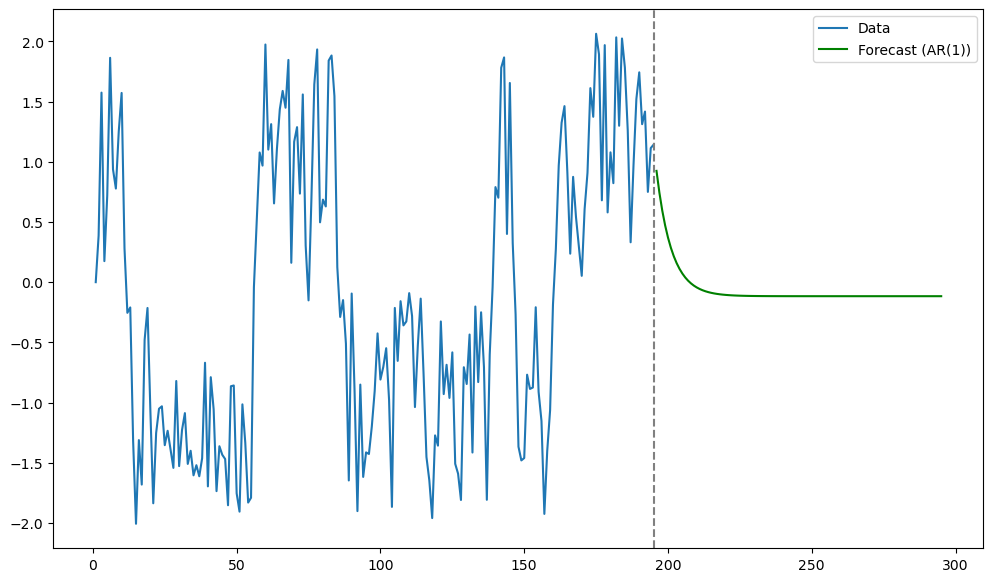

In [37]:
ar = ARIMA(y_sim, order = (1, 0, 0)).fit()
print(ar.summary())
n_y = len(y_sim)
tme = range(1, n_y+1)
k_future = 100 #number of future points for prediction
tme_future = range(n_y+1, n_y+k_future+1)
fcast = ar.get_prediction(start = n_y, end = n_y+k_future-1).predicted_mean
plt.figure(figsize = (12, 7))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, fcast, label = 'Forecast (AR(1))', color = 'green')
plt.axvline(x=n_y, color='gray', linestyle='--')
plt.legend()
plt.show()

Next we will fit the nonlinear AR(1) model using PyTorch. 

In [45]:
class PiecewiseLinearModel(nn.Module):
    def __init__(self, knots_init, beta_init):
        super().__init__()
        self.num_knots = len(knots_init)
        self.beta = nn.Parameter(torch.tensor(beta_init, dtype=torch.float32)) 
        self.knots = nn.Parameter(torch.tensor(knots_init, dtype=torch.float32))

    def forward(self, x):
        knots_sorted, _ = torch.sort(self.knots)
        out = self.beta[0] + self.beta[1] * x
        for j in range(self.num_knots):
            out += self.beta[j + 2] * torch.relu(x - knots_sorted[j])
        return out

In [46]:
y_reg = y_sim[1:]
x_reg = y_sim[0:(n-1)]

y_torch = torch.tensor(y_reg, dtype = torch.float32).unsqueeze(1)
x_torch = torch.tensor(x_reg, dtype = torch.float32).unsqueeze(1)

In [47]:
k = 6
quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_reg, quantile_levels)

n_reg = len(y_reg)
X = np.column_stack([np.ones(n_reg), x_reg])
for j in range(k):
    xc = ((x_reg > knots_init[j]).astype(float))*(x_reg - knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(y_reg, X).fit()
beta_init = md_init.params
print(knots_init)
print(beta_init)

[-1.47418868 -1.05574615 -0.65832485 -0.09346269  0.70088161  1.39251632]
[-2.48088937 -0.77905517  1.14589238  0.11575653  0.79468018  0.80873226
 -2.52554882  0.48737735]


In [48]:
nar = PiecewiseLinearModel(knots_init = knots_init, beta_init = beta_init)

In [49]:
optimizer = optim.Adam(nar.parameters(), lr = 0.01)
loss_fn = nn.MSELoss()

for epoch in range(10000): 
    optimizer.zero_grad()
    y_pred = nar(x_torch)
    loss = loss_fn(y_pred, y_torch)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
#Run this code a few times to be sure of convergence. 

Epoch 0, Loss: 0.3025
Epoch 100, Loss: 0.2982
Epoch 200, Loss: 0.2980
Epoch 300, Loss: 0.2979
Epoch 400, Loss: 0.2978
Epoch 500, Loss: 0.2977
Epoch 600, Loss: 0.2976
Epoch 700, Loss: 0.2976
Epoch 800, Loss: 0.2975
Epoch 900, Loss: 0.2975
Epoch 1000, Loss: 0.2974
Epoch 1100, Loss: 0.2974
Epoch 1200, Loss: 0.2974
Epoch 1300, Loss: 0.2973
Epoch 1400, Loss: 0.2973
Epoch 1500, Loss: 0.2973
Epoch 1600, Loss: 0.2972
Epoch 1700, Loss: 0.2972
Epoch 1800, Loss: 0.2972
Epoch 1900, Loss: 0.2972
Epoch 2000, Loss: 0.2972
Epoch 2100, Loss: 0.2972
Epoch 2200, Loss: 0.2971
Epoch 2300, Loss: 0.2971
Epoch 2400, Loss: 0.2971
Epoch 2500, Loss: 0.2971
Epoch 2600, Loss: 0.2971
Epoch 2700, Loss: 0.2971
Epoch 2800, Loss: 0.2971
Epoch 2900, Loss: 0.2971
Epoch 3000, Loss: 0.2971
Epoch 3100, Loss: 0.2971
Epoch 3200, Loss: 0.2971
Epoch 3300, Loss: 0.2971
Epoch 3400, Loss: 0.2971
Epoch 3500, Loss: 0.2971
Epoch 3600, Loss: 0.2971
Epoch 3700, Loss: 0.2971
Epoch 3800, Loss: 0.2971
Epoch 3900, Loss: 0.2971
Epoch 4000, 

Below we compute the predictions given by the nonlinear AR model. 

In [50]:
last_val = torch.tensor([[y_sim[-1]]], dtype = torch.float32)
future_preds = []
for _ in range(k_future):
    next_val = nar(last_val)
    future_preds.append(next_val.item())
    last_val = next_val.detach()
future_preds_array = np.array(future_preds)


We also compute predictions using the actual function $g$ which generated the data. 

In [51]:
last_val = torch.tensor([[y_sim[-1]]], dtype = torch.float32)
actual_preds = []
for _ in range(k_future):
    next_val = ((2*last_val)/(1 + 0.8 * (last_val ** 2)))
    actual_preds.append(next_val.item())
    last_val = next_val.detach()
actual_preds_array = np.array(actual_preds)


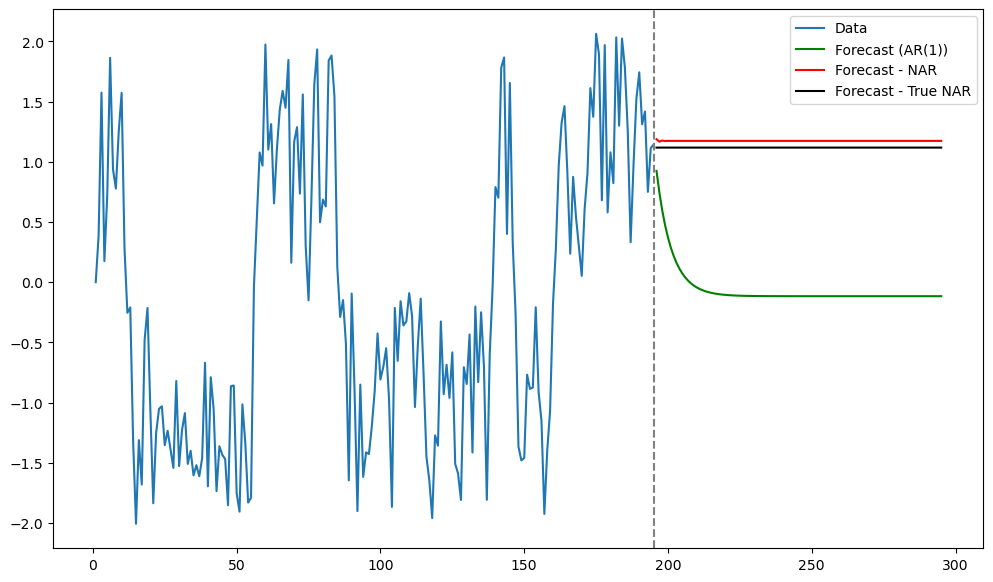

In [52]:
n_y = len(y_sim)
tme = range(1, n_y+1)
tme_future = range(n_y+1, n_y+k_future+1)
fcast = ar.get_prediction(start = n_y, end = n_y+k_future-1).predicted_mean
plt.figure(figsize = (12, 7))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, fcast, label = 'Forecast (AR(1))', color = 'green')
plt.plot(tme_future, future_preds_array, label = 'Forecast - NAR', color = 'red')
plt.plot(tme_future, actual_preds_array, label = 'Forecast - True NAR', color = 'black')
plt.axvline(x=n_y, color='gray', linestyle='--')
plt.legend()
plt.show()